In [2]:
import numpy as np
from scipy.special import expit
from matplotlib import pyplot as plt
from scipy import linalg as la
from scipy import sparse as sp
from numba import jit
from sparse_sgd_3 import sp_rm_sgd, predict
from sklearn.cross_validation import train_test_split as tts

###Getting the code up and running

Before we can run any of the code, we need to preprocess the url dataset. 
You need to run preprocesser.py in your terminal (in the same file that holds all the svm files) to generate the necessary binary files that will take seconds, rather than minutes, to load in. 
This file also puts the dataset in the expected format for the sp_rm_sgd method calls.

In [3]:
# Before loading these arrays, run preprocessor.py to generate the files 'Data.npy,'
# 'Index.npy,' and 'Yvals.npy.'
D = np.load('Data.npy')
I = np.load('Index.npy')
Y = np.load('Yvals.npy')

In [5]:
# Set the N and P values
N = len(D)
P = 3231961 + 1

###Timing the code

In [69]:
%%time
# Run and time the sp_rm_sgd method for the whole dataset
b0 = sp_rm_sgd(D, I, Y, np.ones(N), np.zeros(P), blocksize=1000)

Wall time: 5min 31s


You may be saying to yourself: isn't 5 minutes a little long?

WRONG!

For Python, 5 minutes is a blindingly fast time for this algorithm to process such a large dataset.
Unlike R, Python is not equipped with a robust C++ interface (robust here meaning "has a wrapper for Eigen").
Its two compiled language interfaces are Cython and Numba, neither of which is endowed with the particular tools that would further speed this implementation up: Eigen or lazy evaluation.
Since NumPy wraps BLAS and LAPACK to implement most of its highly optimized functions, NumPy is as fast as it can get for a Pythonic implementation of vector and array manipulation.

That said, multiplying a dense 3,231,962 vector of beta values by a constant at each step (which is what the l2 penalty entails) is still mind-numbingly slow and would take days, let alone hours, to complete. 
Furthermore, the scipy sparse matrix class is not--ahem--robust.
That is why I have chosen to optimize the Robbin's Monro SGD method using what I like to call "poor man's lazy evaluation."
Essentially, we split the dataset into manageable chunks of samples (here, size 1000) and calculate the nontrivial indices that correspond to the entire chunk. 
Since the chunk is fairly small, so too is the number of indices we have to update at each step.
Thus we only update the b0 values at the indices that will be effected by the sample, the "bindex'.
At each step in the batch, we calculate the l2 penalty and gradient using only the bindex values (since the gradient will have trivial values corresponding to the trivial values of the sample).
Finally, at the end of the 1000 iterations, we update the b0 values that were never affected by any of the batch samples by subtracting the sum of all of the penalty terms that would have been taken from these b0 values over the course of the batch.

Please see sparse_sgd_3.py for the implementation.

##Testing Accuracy
In the following tests for accuracy, we split the data into training and testing sets by using sklearn.cross_validation.train_test_split(). 
This function generates indices for our training and testing sets respectively.
We make predictions and test the accuracy of those predictions using the predict function found in sparse_sgd_3.py

###Accuracy based on test size
To test the accuracy of our optimized, sparse implementation of rm sgd, we run each the algorithm and make predictions for a variety of test sizes: $\{.1, .2, .3, .4, .5, .6, .7, .8, .9, .99\}$. 
Note that because it takes the function about 5 minutes to run on the full dataset, the following cells take some time to run.

In [10]:
# Calculate the accuracy for various test sizes.
# Since this takes about 20 minutes to run, it has been split in two.
acc = []
for i in np.arange(.1, .6, .1):
    trainindex, testindex = tts(np.arange(N), test_size=i)
    b0 = sp_rm_sgd(D[trainindex], I[trainindex], Y[trainindex], np.ones(N), np.zeros(P), blocksize=1000)
    acc.append(predict(D[testindex], I[testindex], Y[testindex], b0))

In [18]:
for i in np.arange(.6, 1, .1):
    trainindex, testindex = tts(np.arange(N), test_size=i)
    b0 = sp_rm_sgd(D[trainindex], I[trainindex], Y[trainindex], np.ones(N), np.zeros(P), blocksize=1000)
    acc.append(predict(D[testindex], I[testindex], Y[testindex], b0))

In [24]:
# Take an additional training and testing set with a test size close to 1.
# Note that this takes far less time, but still has a reasonably high standard of 
# accuracy, about 96. %
trainindex, testindex = tts(np.arange(N), test_size=.99)
b0 = sp_rm_sgd(D[trainindex], I[trainindex], Y[trainindex], np.ones(N), np.zeros(P), blocksize=1000)
acc.append(predict(D[testindex], I[testindex], Y[testindex], b0))

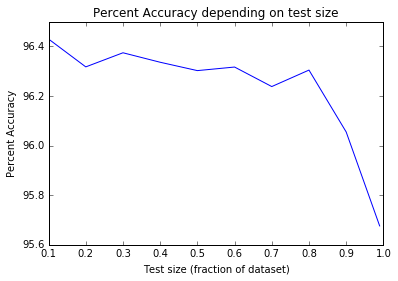

In [57]:
# Plot the accuracy of the predictions for various test sizes
%matplotlib inline
plt.plot([.1,.2,.3,.4,.5,.6,.7,.8,.9,.99], acc)
plt.xlabel('Test size (fraction of dataset)')
plt.ylabel('Percent Accuracy')
plt.title('Percent Accuracy depending on test size')
plt.show()

As we can see from the plot above, though the accuracy of the algorithm did marginally decrease with the increase in the test size percentage, the accuracy remains about 96.0%. 
Test sizes of .1 and .3 had the greatest success, but this success was not considerably higher than that achieved with a smaller training set (and a smaller time cost). 
Because the time cost to test on the smaller training set is lower, with a reasonably high accuracy, we will use .99 as our test size for the remaining comparisons.

###Accuracy based on penalty coefficient

In the following code, we test various values of the penalty coefficient, $\lambda$, for a .99 test size on the url dataset.
Note that the default value for $\lambda$ is relatively small--$1 \times 10^{-5}$.

In [28]:
# Demonstrate the effect of the lambda values
# Note that we train on the same test and training sets, changing only the lambda
# values. Since the .99 test size still has high accuracy with far less time cost,
# we train using this test size (a .01 training size)
lambdas = [1, .5, .1, .01, .001, .0001, .00001]
trainindex, testindex = tts(np.arange(N), test_size=.99)

lam_acc = []
for i in lambdas:
    b0 = sp_rm_sgd(D[trainindex], I[trainindex], Y[trainindex], np.ones(N), np.zeros(P), lam=i, blocksize=1000)
    lam_acc.append(predict(D[testindex], I[testindex], Y[testindex], b0))

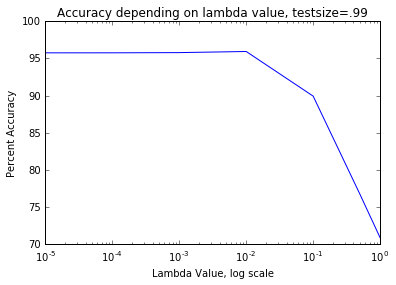

In [47]:
plt.semilogx(lambdas, lam_acc)
plt.xlabel('Lambda Value, log scale')
plt.ylabel('Percent Accuracy')
plt.title('Accuracy depending on lambda value, testsize=.99')
plt.show()

As we can see from the above plot, the algorithm maintains about 96% accuracy for most relatively low $\lambda$ values: $\{.00001, .0001, .001, .01\}$. 
However, for larger values of $.1, .5$ and $1$, the accuracy of the algorithm drops considerably:


In [68]:
# Demonstrate the accuracy associated with the highest lambda values
print "Accuracy for lambda = 1, .5, .1:", lam_acc[:3]
# Calculate the percentage of zero labels
print "Percentage of zero labels:", (1-(Y > 0).sum() / float(N)) * 100

Accuracy for lambda = 1, .5, .1: [70.90704751642906, 76.741876316569346, 89.939376157432292]
Percentage of zero labels: 66.9406501317


From the more specific report above, we see that when $\lambda = 1$, using the algorithm results in accuracy only about 3% higher than simply predicting 0 for every sample.
Similarly, when $\lambda = .5$, using the algorithm results in accuracy only about 10% higher than naively guessing 0 for each sample.
Clearly, the choice of penalty coefficient has great effect on the algorithm's predictive capacity--apparently greater than test size.

### Accuracy based on the initial guess

The careful reader will note that in the previous runs of the sparse Robbins Monro SGD code, our initial guess for b0 has always simply been an array of zeros. 
Here we investigate the effect of other initial guess vectors: a vector of random values and a vector of ones (again with the standard of 0's)

In [51]:
# Compare accuracy of predictions for a random initial vector vs. an initial vector of zeros
trainindex, testindex = tts(np.arange(N), test_size=.99)
b0 = sp_rm_sgd(D[trainindex], I[trainindex], Y[trainindex], np.ones(N), np.random.rand(P))
predict(D[testindex], I[testindex], Y[testindex], b0)

87.523401578892575

In [54]:
# Test using an initial vector of zeros.
b0 = sp_rm_sgd(D[trainindex], I[trainindex], Y[trainindex], np.ones(N), np.ones(P))
predict(D[testindex], I[testindex], Y[testindex], b0)

81.658389431781629

In [52]:
# Test using an initial vector of zeros.
b0 = sp_rm_sgd(D[trainindex], I[trainindex], Y[trainindex], np.ones(N), np.zeros(P))
predict(D[testindex], I[testindex], Y[testindex], b0)

96.095345652017201

Clearly, the initial choice of beta does affect the accuracy of the algorithm.
It is likely that the initial choice of zeros alone is most effective because it does not include the influence of random noise or a random initial guess but is rather solely influenced by the data at hand.
The influence of the intial guess vector on the algorithm (and its comparative influence on other such algorithms) would be an interesting area of further study.